/tmp/ipython-input-6-417329130.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', len(recortes))


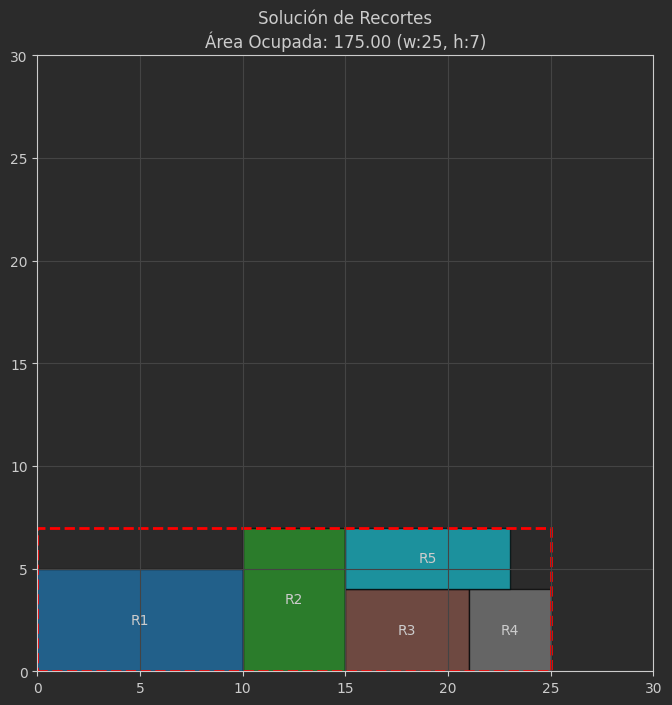

Mejor área ocupada: 175


In [ ]:
# -*- coding: utf-8 -*-
"""ae_ts_recortes_01.ipynb

Automatically generated by Colab.

Original file is located at

"""

import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({
    'figure.facecolor': '#2b2b2b',     # fondo exterior
    'axes.facecolor':   '#2b2b2b',     # fondo del área del gráfico
    'axes.edgecolor':   '#cccccc',     # borde de los ejes
    'axes.labelcolor':  '#cccccc',     # etiquetas de los ejes
    'xtick.color':      '#cccccc',     # color de los números en el eje X
    'ytick.color':      '#cccccc',     # color de los números en el eje Y
    'text.color':       '#cccccc',     # color del título y textos
    'grid.color':       '#444444',     # color de la grilla
})

# -----------------------------------------------------------------------------
# Función que calcula el área ocupada por los recortes en la tela
# -----------------------------------------------------------------------------
def calcular_area_ocupada(posiciones, recortes):
    if not posiciones:
        return 0
    max_x = max([pos[0] + rec[0] for pos, rec in zip(posiciones, recortes)])
    max_y = max([pos[1] + rec[1] for pos, rec in zip(posiciones, recortes)])
    return max_x * max_y

# -----------------------------------------------------------------------------
# Función que verifica si los recortes se superponen
# -----------------------------------------------------------------------------
def hay_superposicion(posiciones, recortes):
    for i in range(len(recortes)):
        for j in range(i + 1, len(recortes)):
            x1, y1 = posiciones[i]
            x2, y2 = posiciones[j]
            w1, h1 = recortes[i]
            w2, h2 = recortes[j]

            # Verificar si hay superposición en ambos ejes
            if not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1):
                return True
    return False

# -----------------------------------------------------------------------------
# Función para generar una solución inicial válida (no necesariamente óptima)
# -----------------------------------------------------------------------------
def generar_solucion_inicial(recortes, max_width, max_height):
    posiciones = []
    for i in range(len(recortes)):
        colocado = False
        for y in range(max_height):
            for x in range(max_width):
                pos_actual = (x, y)
                posiciones.append(pos_actual)
                if not hay_superposicion(posiciones, recortes[:i+1]):
                    colocado = True
                    break
                else:
                    posiciones.pop()
            if colocado:
                break
        if not colocado:
            # Si un recorte no se pudo colocar, la solución inicial es inválida
            return None
    return posiciones

# -----------------------------------------------------------------------------
# generacion de vecindarios
# -----------------------------------------------------------------------------
def generar_vecindarios(posiciones, recortes, max_width, max_height):
    vecindarios = []
    num_recortes = len(posiciones)

    for i in range(num_recortes):
        # Generar un pequeño número de movimientos aleatorios para cada recorte
        for _ in range(5):  # Generar 5 vecinos por cada recorte para explorar más
            nueva_posicion = (
                random.randint(0, max_width - recortes[i][0]),
                random.randint(0, max_height - recortes[i][1])
            )

            nuevas_posiciones = posiciones[:]
            nuevas_posiciones[i] = nueva_posicion

            # El movimiento se define por el índice del recorte y su nueva posición
            movimiento = (i, nueva_posicion)
            vecindarios.append((nuevas_posiciones, movimiento))

    return vecindarios

# -----------------------------------------------------------------------------
# Algoritmo de búsqueda tabú para el problema de recortes
# -----------------------------------------------------------------------------
def busqueda_tabu_recortes(recortes, max_width, max_height, num_iteraciones, tamanio_lista_tabu):
    # Inicialización
    posiciones_actuales = generar_solucion_inicial(recortes, max_width, max_height)
    if posiciones_actuales is None:
        print("No se pudo generar una solución inicial válida.")
        return [], float('inf')

    mejor_posicion = posiciones_actuales[:]
    mejor_area = calcular_area_ocupada(mejor_posicion, recortes)

    # Crear la lista tabú
    lista_tabu = []

    for iteracion in range(num_iteraciones):
        # Se genera una nueva posición basada en la anterior
        vecindarios = generar_vecindarios(posiciones_actuales, recortes, max_width, max_height)

        # Inicializar variables para encontrar el mejor vecindario
        mejor_vecindario = None
        mejor_movimiento_candidato = None
        mejor_area_vecindario = float('inf')

        # Evaluar los vecindarios
        for vecindario, movimiento in vecindarios:
            if not hay_superposicion(vecindario, recortes):
                area_vecindario = calcular_area_ocupada(vecindario, recortes)

                # Criterio de aspiración y condición Tabú
                if (movimiento not in lista_tabu or area_vecindario < mejor_area):
                    if area_vecindario < mejor_area_vecindario:
                        mejor_vecindario = vecindario
                        mejor_area_vecindario = area_vecindario
                        mejor_movimiento_candidato = movimiento

        # Actualizar la posición actual
        if mejor_vecindario is not None:
            posiciones_actuales = mejor_vecindario[:]

            # Actualizar la lista tabú
            lista_tabu.append(mejor_movimiento_candidato)
            if len(lista_tabu) > tamanio_lista_tabu:
                lista_tabu.pop(0)

            if mejor_area_vecindario < mejor_area:
                mejor_posicion = mejor_vecindario[:]
                mejor_area = mejor_area_vecindario

    return mejor_posicion, mejor_area

# -----------------------------------------------------------------------------
# Función para visualizar los recortes
# -----------------------------------------------------------------------------
def graficar_solucion(posiciones, recortes, max_width, max_height, titulo="Solución de Recortes"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, max_width)
    ax.set_ylim(0, max_height)
    ax.set_title(titulo)
    ax.grid(True)

    colores = plt.cm.get_cmap('tab10', len(recortes))
    for i, (pos, rec) in enumerate(zip(posiciones, recortes)):
        ax.add_patch(patches.Rectangle(pos, rec[0], rec[1], edgecolor='black', facecolor=colores(i), alpha=0.7))
        ax.text(pos[0] + rec[0]/2, pos[1] + rec[1]/2, f'R{i+1}', ha='center', va='center')

    # Dibujar el bounding box de la solución
    if posiciones:
        area_total = calcular_area_ocupada(posiciones, recortes)
        bound_w = max([p[0] + r[0] for p, r in zip(posiciones, recortes)])
        bound_h = max([p[1] + r[1] for p, r in zip(posiciones, recortes)])
        ax.add_patch(patches.Rectangle((0, 0), bound_w, bound_h, edgecolor='red', facecolor='none', lw=2, linestyle='--'))
        ax.set_title(f'{titulo}\nÁrea Ocupada: {area_total:.2f} (w:{bound_w}, h:{bound_h})')


    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# -----------------------------------------------------------------------------
# Parámetros y ejecución del algoritmo
# -----------------------------------------------------------------------------
recortes = [(10, 5), (5, 7), (6, 4), (4, 4), (8, 3)]  # Dimensiones de los recortes (ancho, alto)
max_width = 30  # Ancho del plano (tela)
max_height = 30  # Alto del plano (tela)
num_iteraciones = 100
tamanio_lista_tabu = 10

# Ejecutar la búsqueda tabú
mejores_posiciones, mejor_area = busqueda_tabu_recortes(recortes, max_width, max_height, num_iteraciones, tamanio_lista_tabu)

# Graficar el resultado
graficar_solucion(mejores_posiciones, recortes, max_width, max_height)

print(f"Mejor área ocupada: {mejor_area}")